In [1]:
# Copyright (c) Xuanyi Dong [GitHub D-X-Y], 2020.06 
# Copyright 2025 Anonymized Authors

# Licensed under the Apache License, Version 2.0 (the "License"); 
# you may not use this file except in compliance with the License. 
# You may obtain a copy of the License at
# https://www.apache.org/licenses/LICENSE-2.0
"""
This experiment tests the generalization ability of GENE testing it against 
regularized evolution and REINFORCE as implemented in Dong et al (2021). 

Requirements: 

- This notebook requires that torchvision, torch, tensorflow and numpy be
 installed within the Python environment you are running this script in. 

- This notebook requires the submodule autodl. See setup in README

- make sure to have outputs saved at correct location ../outputs/search-tss/
 
"""
import matplotlib.pyplot as plt
import subprocess

import sys; sys.path.append('..')
from utils.plotting import visualize_curve
from nats_bench import create

api = create(None, "tss", fast_mode=True, verbose=False)

[2025-03-09 15:39:53] Try to use the default NATS-Bench (topology) path from fast_mode=True and path=None.


In [ ]:
# we can start define experiments from the provided script in our autodl submodule
import subprocess
import os

def run_algorithm(algname, dataset, budget, loops): 
    algorithms = {

        # custom scripts like this
        "GENE": os.path.join("4_GENE.py"),

        # baselines provided from autodl lib
        "regularized evolution": os.path.join("..", "thirdparty", "autodl", "exps", "NATS-algos", "regularized_ea.py"),
        "random": os.path.join("..", "thirdparty", "autodl", "exps", "NATS-algos", "random_wo_share.py"),
        "reinforce": os.path.join("..", "thirdparty", "autodl", "exps", "NATS-algos", "reinforce.py"),
        "bohb": os.path.join("..", "thirdparty", "autodl", "exps", "NATS-algos", "bohb.py"),
        
    }
    # Use os.path.join to construct the save_dir
    save_dir = os.path.join("..", "output", "search")

    print(f"Running algorithm {algname} on {dataset}...")
    command = [
        "python", 
        algorithms[algname],
        "--save_dir", save_dir, 
        "--dataset", dataset,
        "--search_space", "tss",
        "--time_budget", str(budget),
        "--loops_if_rand", str(loops),

    ]

    if algname== "regularized evolution" or algname== "regularized evolution gm": 
        command += ["--ea_cycles", "200","--ea_population", "20","--ea_sample_size", "10"]

    if algname=="bohb":
        command += ["--num_samples", "4", "--random_fraction", "0.0", "--bandwidth_factor","3"]

    if algname=="reinforce":
        command += ["--learning_rate", "0.01"]


    # Run the command
    result = subprocess.run(command, capture_output=True, text=True)

    # if no outputs are saved, check this command
    # print(result)


In [ ]:
algorithms = [
    "GENE",
    "regularized evolution",
    "reinforce",
]
datasets = {
    "cifar10" : 200000,
    "cifar100" : 400000,
    "ImageNet16-120": 120000,
}

n = 1000

for algorithm in algorithms:
    for dataset, budget in datasets.items():
        run_algorithm(algorithm, dataset, budget, n)

Running algorithm GENE on cifar10...
Running algorithm GENE on cifar100...
Running algorithm GENE on ImageNet16-120...
Running algorithm regularized evolution on cifar10...
Running algorithm regularized evolution on cifar100...
Running algorithm regularized evolution on ImageNet16-120...
Running algorithm reinforce on cifar10...
Running algorithm reinforce on cifar100...
Running algorithm reinforce on ImageNet16-120...


In [12]:
# next, we will look into the NATS-Bench
from collections import OrderedDict
from nats_bench import create
from scipy.stats import t
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import clear_output
from scipy.stats import t # for statistical testing
import numpy as np

# as this library saves its data in its individual files, we will only use 
# scripts to access and read out the results and then visualize them. 


# we expect to fetch data from ../output/search/tss
def fetch_data(root_dir=None, search_space="tss", dataset=None, algorithms=["REA","REINFORCE", "RANDOM", "GENE", "GE", "BOHB"]):
    if root_dir is None:
        root_dir = os.path.join("..", "output", "search")
    ss_dir = "{:}-{:}".format(root_dir, search_space)
    alg2name, alg2path = OrderedDict(), OrderedDict()
    for alg in algorithms:
        alg2name[alg] = alg
    for alg, name in alg2name.items():
        alg2path[alg] = os.path.join(ss_dir, dataset, name, "results.pth")
        assert os.path.isfile(alg2path[alg]), "invalid path : {:}".format(alg2path[alg])
    alg2data = OrderedDict()
    for alg, path in alg2path.items():
        data = torch.load(path)
        for index, info in data.items():
            info["time_w_arch"] = [
                (x, y) for x, y in zip(info["all_total_times"], info["all_archs"])
            ]
            for j, arch in enumerate(info["all_archs"]):
                assert arch != -1, "invalid arch from {:} {:} {:} ({:}, {:})".format(
                    alg, search_space, dataset, index, j
                )
        alg2data[alg] = data
    return alg2data


def query_performance(api, data, dataset, ticket):
    results, is_size_space = [], api.search_space_name == "size"
    for i, info in data.items():
        time_w_arch = sorted(info["time_w_arch"], key=lambda x: abs(x[0] - ticket))
        time_a, arch_a = time_w_arch[0]
        time_b, arch_b = time_w_arch[1]
        info_a = api.get_more_info(
            arch_a, dataset=dataset, hp=90 if is_size_space else 200, is_random=False
        )
        info_b = api.get_more_info(
            arch_b, dataset=dataset, hp=90 if is_size_space else 200, is_random=False
        )
        accuracy_a, accuracy_b = info_a["test-accuracy"], info_b["test-accuracy"]
        interplate = (time_b - ticket) / (time_b - time_a) * accuracy_a + (
            ticket - time_a
        ) / (time_b - time_a) * accuracy_b
        results.append(interplate)
    return np.mean(results), np.std(results)


def show_valid_test(api, data, dataset):
    valid_accs, test_accs, is_size_space = [], [], api.search_space_name == "size"
    for i, info in data.items():
        time, arch = info["time_w_arch"][-1]
        if dataset == "cifar10":
            xinfo = api.get_more_info(
                arch, dataset=dataset, hp=90 if is_size_space else 200, is_random=False
            )
            test_accs.append(xinfo["test-accuracy"])
            xinfo = api.get_more_info(
                arch,
                dataset="cifar10-valid",
                hp=90 if is_size_space else 200,
                is_random=False,
            )
            valid_accs.append(xinfo["valid-accuracy"])
        else:
            xinfo = api.get_more_info(
                arch, dataset=dataset, hp=90 if is_size_space else 200, is_random=False
            )
            valid_accs.append(xinfo["valid-accuracy"])
            test_accs.append(xinfo["test-accuracy"])
    valid_str = "{:.2f}$\pm${:.2f}".format(np.mean(valid_accs), np.std(valid_accs))
    test_str = "{:.2f}$\pm${:.2f}".format(np.mean(test_accs), np.std(test_accs))
    return valid_str, test_str


ylims ={
    "tss" : {
        "cifar10": (91,94.3),
        "cifar100": (69,75.0),
        "ImageNet16-120": (42,52)
    },
    "sss" : {
        "cifar10": (92,93.3),
        "cifar100": (65,70.5),
        "ImageNet16-120": (40,46)
    }
}



def visualize_curve(api, exp, dataset, ax, search_space="tss"):
    def sub_plot_fn(ax, dataset, exp):
        xdataset, max_time = dataset.split("-T")
        algorithms_labels = [d[0] for d in exp["data"].items()]
        algorithms = [d[1][0] for d in exp["data"].items()]
        alg2data = fetch_data(search_space=search_space, dataset=dataset, algorithms=algorithms)
        total_tickets = 150
        time_tickets = [
            float(i) / total_tickets * int(max_time) for i in range(total_tickets)
        ]
        tc = {
            'Dark Blue': '#006BA4',
            'Blue': '#5F9ED1',
            'Light Blue': '#A2C8EC',
            'Dark Orange': '#FF800E',
            'Red Orange': '#C85200',
            'Light Orange': '#FFBC79',
            'Very Dark Gray': '#595959',
            'Dark Gray': '#898989',
            'Light Gray': '#ABABAB',
            'Very Light Gray': '#CFCFCF',
            "Green" : '#228B22',
            "Red" : '#FF4500' 
        }
        colors = [tc[d[1][1]] for d in exp["data"].items()]

        # ax.set_xlim(0,exp["config"]["budget"]) # to make it easier for different experiments, we encode budget in name
        ax.set_xlim(0,int(max_time))
        
        ax.set_ylim(
            exp["config"]["limits"][xdataset][0], exp["config"]["limits"][xdataset][1]
        )

        xs = [x for x in time_tickets]

        for idx, (alg, data) in enumerate(alg2data.items()):
            accuracies = []
            ci_lower = []
            ci_upper = []
            repeats = len(data)
            for ticket in time_tickets:
                cur_mean, cur_std = query_performance(api, data, xdataset, ticket)
                accuracies.append(cur_mean)
                if exp["config"]["confidence_intervall"] is True:

                    # Calculate the confidence interval
                    sem = cur_std / np.sqrt(repeats)  # Standard Error
                    confidence = 1 - exp["config"]["pvalue"]
                    t_critical = t.ppf(confidence + (1 - confidence) / 2, repeats - 1)
                    margin_of_error = t_critical * sem
                        
                    ci_lower.append(cur_mean - margin_of_error)
                    ci_upper.append(cur_mean + margin_of_error)
                    
            ax.plot(
                xs,
                accuracies,
                c=colors[idx],
                label="{:}".format(algorithms_labels[idx]),
            )
            if exp["config"]["confidence_intervall"] is True:
                ax.fill_between(xs, ci_lower, ci_upper, alpha=0.5, linewidth=0, facecolor=colors[idx])

            ax.set_ylabel("accuracy")
            ax.set_xlabel('total training time spent (seconds)')

            name2label = {
                "cifar10": "CIFAR-10",
                "cifar100": "CIFAR-100",
                "ImageNet16-120": "ImageNet-16-120",
            }
            ax.set_title("NATS-Bench results on {:}".format(name2label[xdataset]))
            formatter = ticker.ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((1,4))
            ax.xaxis.set_major_formatter(formatter)
            # ax.xaxis.set_major_locator(ticker.MultipleLocator(100))


        ax.legend(loc=4)
    sub_plot_fn(ax, dataset, exp)
    print("sub-plot {:} on {:} done.".format(dataset, search_space))
    




sub-plot cifar10-T200000 on tss done.
sub-plot cifar100-T400000 on tss done.
sub-plot ImageNet16-120-T120000 on tss done.


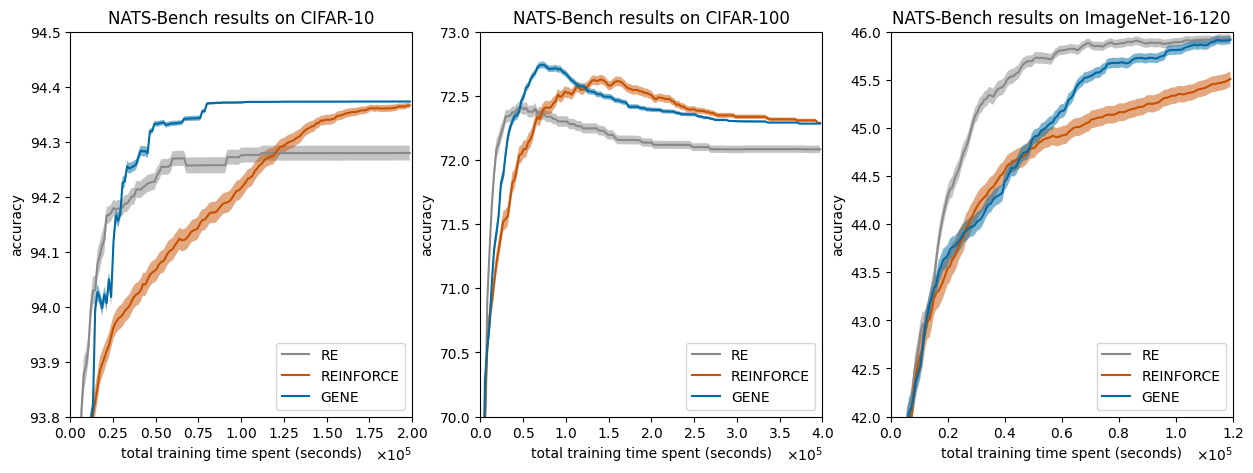

In [ ]:
# exp4_4: compare on all datasets
ylims = {
        "cifar10": (93.8,94.5),
        "cifar100": (70,73),
        "ImageNet16-120": (42,46)}


exp4_4 = {
    "data": 
    {
        "RE" : ["R-EA-SS10","Dark Gray"],
        "REINFORCE" : ["REINFORCE-0.01","Red Orange"],
        "GENE" : ["GM","Dark Blue"],

    },
    "config": 
    {
        "limits" : ylims,
        "n" : 1000,
        "confidence_intervall" : True,
        "pvalue" : 0.05,
   }
}

# multiple plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
visualize_curve(api, exp4_4, "cifar10-T200000", axes[0])
visualize_curve(api, exp4_4, "cifar100-T400000", axes[1])
visualize_curve(api, exp4_4, "ImageNet16-120-T120000", axes[2])

plt.savefig('nats_all.png', dpi=500, bbox_inches='tight')
plt.show()
